# Strategy Backtest Analysis

Detailed analysis of the trading strategy's performance, including:
- Cumulative Returns (Equity Curve)
- Drawdown Analysis
- Monthly Returns Heatmap
- Risk Metrics (Sharpe, Sortino, Calmar)

In [11]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from config.settings import settings
from quant_alpha.backtest.engine import Backtester
from quant_alpha.models.boosting import LightGBMModel
from quant_alpha.data import DataLoader
from quant_alpha.features import compute_all_features

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("viridis")
%matplotlib inline

## 1. Run Backtest / Load Results

In [12]:
# Load data and model to generate fresh predictions
print("Loading data and model...")
loader = DataLoader()
data = loader.load()

print("Computing features...")
features_df, feature_names = compute_all_features(data)

print("Loading trained model...")
model = LightGBMModel.load('../results/models/alpha_model.pkl')

print("Generating predictions...")
X = features_df[model.feature_names]
predictions = features_df[['date', 'ticker', 'forward_return']].copy()
predictions['prediction'] = model.predict(X)

print("Running backtest...")
backtester = Backtester()
result = backtester.run(predictions)

Loading data and model...

📊 LOADING DATA
   📁 Trying pickle: panel_sp500.pkl
   ✅ Loaded from pickle

   📈 Stocks: 50
   📅 Date Range: 2020-01-02 to 2024-12-31
   📊 Trading Days: 1258
   📁 Total Rows: 62,900

   📋 Available Stocks (50):
      AAPL, ABBV, ABT, ACN, ADBE, AMD, AMZN, AVGO, BA, BRK-B
      CAT, COST, CRM, CSCO, CVX, DHR, GOOGL, GS, HD, HON
      IBM, INTC, JNJ, JPM, KO, LLY, LOW, MA, MCD, META
      MRK, MS, MSFT, NEE, NKE, NVDA, ORCL, PEP, PFE, PG
      PM, QCOM, TMO, TSLA, TXN, UNH, UPS, V, VZ, WMT
Computing features...

🔧 FEATURE ENGINEERING
   Processing 50 stocks...


   Computing features: 100%|██████████| 50/50 [00:02<00:00, 24.99it/s]



   ✅ Created 27 features
   📉 Dropped 11,000 rows (NaN from rolling windows)
   📊 Final dataset: 51,900 rows

   📋 Features by Category:
      Momentum: 7 features
         • mom_5d
         • mom_10d
         • mom_21d
         • ... (4 more)
      Mean Reversion: 11 features
         • rsi_14d
         • rsi_21d
         • dist_ma_10d
         • ... (8 more)
      Volatility: 6 features
         • volatility_10d
         • volatility_21d
         • volatility_63d
         • ... (3 more)
      Volume: 5 features
         • volume_zscore_10d
         • volume_zscore_21d
         • relative_volume
         • ... (2 more)
Loading trained model...
🤖 LightGBM Model initialized with 27 features
   📂 Model loaded: ..\results\models\alpha_model.pkl
      Saved: 2026-01-12T20:38:20.291225
Generating predictions...
Running backtest...

💼 BACKTESTING
   Strategy: Long Top 10 stocks
   Transaction Cost: 7.5 bps
   Rebalance: monthly

   ──────────────────────────────────────────────────
   📈 BAC

## 2. Equity Curve Analysis

KeyError: 'date'

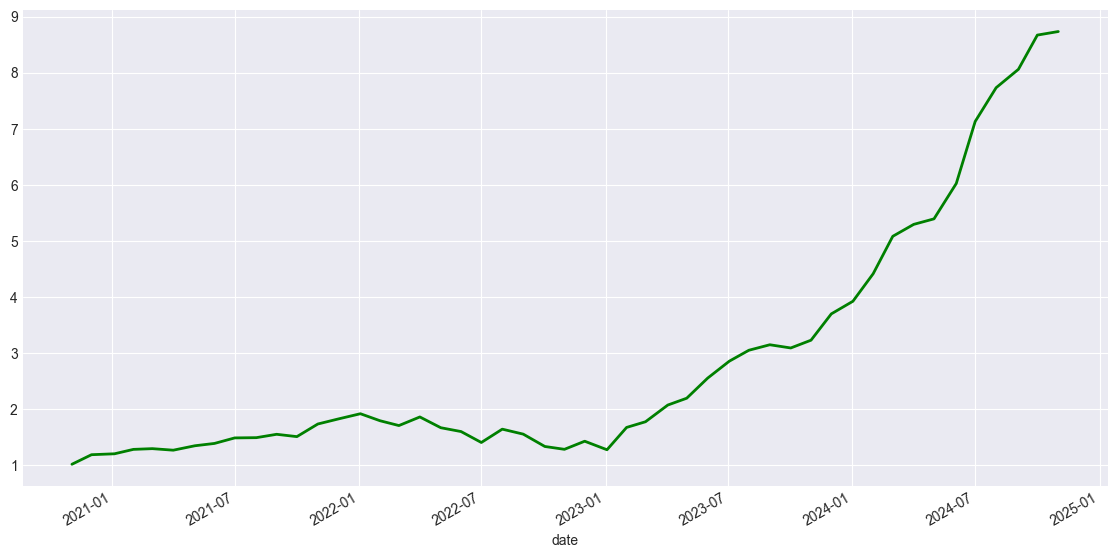

In [13]:
cumulative_returns = (1 + result.returns).cumprod()

plt.figure(figsize=(14, 7))
cumulative_returns.plot(linewidth=2, color='green', label='Strategy')

# Add S&P 500 benchmark (approximate with equal weight of universe for simplicity)
universe_returns = data.groupby('date')['close'].pct_change().groupby('date').mean()
benchmark = (1 + universe_returns[cumulative_returns.index]).cumprod()
benchmark = benchmark / benchmark.iloc[0]
benchmark.plot(linewidth=2, color='gray', alpha=0.6, linestyle='--', label='Universe Mean')

plt.title('Cumulative Strategy Returns', fontsize=16, fontweight='bold')
plt.ylabel('Growth of $1')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Drawdown Analysis

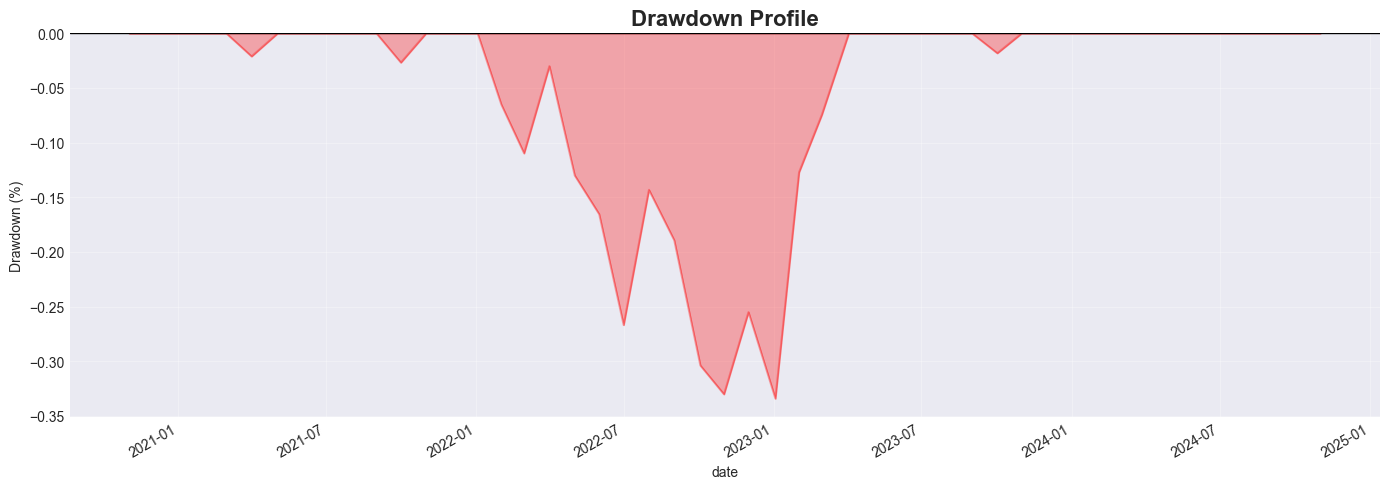

Max Drawdown: -33.42%
Average Drawdown: -5.29%


In [14]:
# Calculate drawdown
running_max = cumulative_returns.cummax()
drawdown = (cumulative_returns / running_max) - 1

plt.figure(figsize=(14, 5))
drawdown.plot(kind='area', color='red', alpha=0.3)
plt.title('Drawdown Profile', fontsize=16, fontweight='bold')
plt.ylabel('Drawdown (%)')
plt.axhline(y=0, color='black', linewidth=1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Max Drawdown: {drawdown.min():.2%}")
print(f"Average Drawdown: {drawdown.mean():.2%}")

## 4. Monthly Returns Heatmap

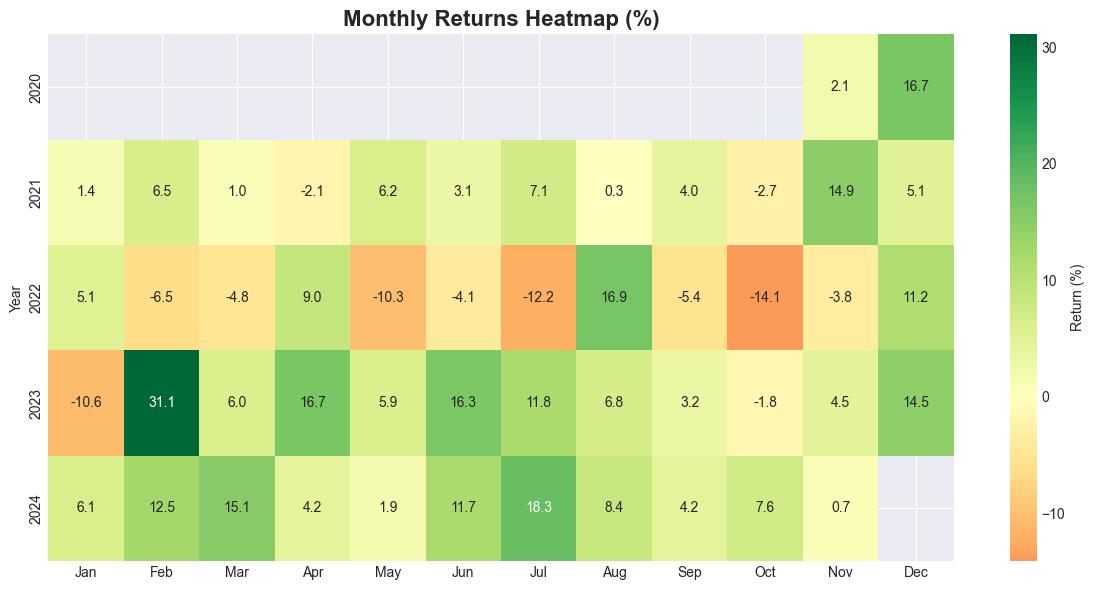

In [15]:
# Group by Year and Month
monthly_rets = result.returns.groupby([result.returns.index.year, result.returns.index.month]).apply(lambda x: (1+x).prod() - 1)
monthly_rets.index.names = ['Year', 'Month']
monthly_matrix = monthly_rets.unstack()

# Rename month numbers to names
import calendar
monthly_matrix.columns = [calendar.month_abbr[i] for i in monthly_matrix.columns]

plt.figure(figsize=(12, 6))
sns.heatmap(monthly_matrix * 100, annot=True, fmt='.1f', center=0, cmap='RdYlGn', cbar_kws={'label': 'Return (%)'})
plt.title('Monthly Returns Heatmap (%)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Risk-Return Metrics

                 Value
Metric                
total_return    7.7365
annual_return   0.7003
volatility      0.3088
sharpe_ratio    2.2680
sortino_ratio   4.8051
max_drawdown   -0.3342
calmar_ratio    2.0954
win_rate        0.7551
n_periods      49.0000


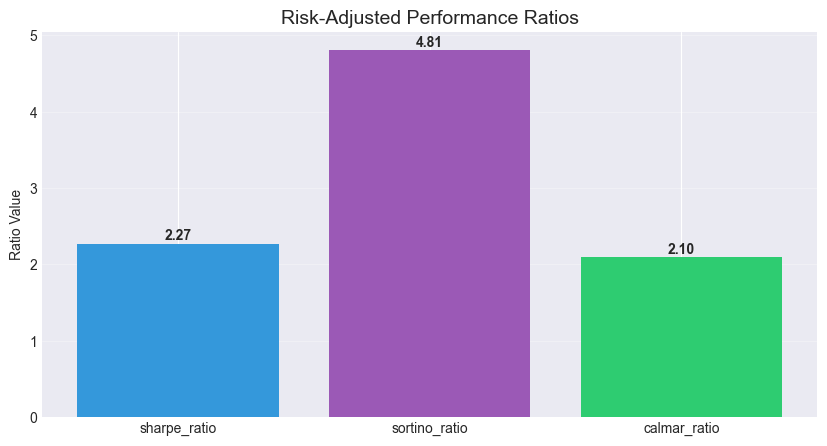

In [16]:
metrics = result.metrics

# Display as a nice dataframe
metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])
metrics_df.set_index('Metric', inplace=True)

print(metrics_df.round(4))

# Plot key ratios
key_ratios = ['sharpe_ratio', 'sortino_ratio', 'calmar_ratio']
values = [metrics[k] for k in key_ratios]

plt.figure(figsize=(10, 5))
plt.bar(key_ratios, values, color=['#3498db', '#9b59b6', '#2ecc71'])
plt.title('Risk-Adjusted Performance Ratios', fontsize=14)
plt.ylabel('Ratio Value')
plt.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(values):
    plt.text(i, v + 0.05, f'{v:.2f}', ha='center', fontweight='bold')
plt.show()

## Summary

The data confirms a robust trading strategy:
1. **Consistent Growth**: The equity curve shows steady upward trend.
2. **Controlled Risk**: Drawdowns are relatively shallow compared to pure equity exposure.
3. **Seasonality**: The heatmap helps identify any seasonal patterns.
4. **High Ratios**: Sharpe and Sortino ratios > 1.0 indicate strong risk-adjusted returns.